In [1]:
import os, json
import pandas as pd
import json 
import plotly.express as px
from IPython.display import Image
import re
import gc
import string
import time
from concurrent.futures import ProcessPoolExecutor

from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from gensim.models.callbacks import CallbackAny2Vec
from polyleven import levenshtein

import pickle

# Data Cleaning 

In [2]:
def filterPage(pages):
    if len(pages) == 4 :
        return [(page,content) for page,content in enumerate(pages[:-1])]
    elif (len(pages) == 6) or (len(pages) == 8):
        return [(page,content) for page,content in enumerate(pages[:-2])]
    else : 
        return []
    
def getOCRconfidence(confidence):
    return float(confidence[0].split()[-1].replace(',','.'))

def getAlphaRatio(content):
    return sum([(c.isalpha() and c.islower()) or (c == ' ') for c in content])/len(content)



# Class for cleaning such that the regex don't have to be compiled each time
class CleanText:
    def __init__(self):
        self.essentialNonAlpha = re.escape("!',-.:;?\n")
        self.noisyChar = re.compile(f'[^\w{self.essentialNonAlpha}]')
        self.essentialPunct = re.escape("!,.:;?")
        self.stickingPunct = re.compile(f'(?:(?<=[\!\?\.])(?=[A-ZÀ-Ÿ])|(?<=[,:;])(?=[a-zà-ÿ]))')
        self.noisyStickingPunct = re.compile('[\!\?\.][^a-zà-ÿA-ÿ]*(?=[a-zà-ÿ])')
        self.noisyPunctSequence = re.compile(f'(?<=[{self.essentialNonAlpha}])[^a-zA-ZÀ-ÿ\n\.][^a-zA-ZÀ-ÿ\n]*')
        self.dashMatching = re.compile('(?<=[a-zà-ÿA-ÿ])[^a-zà-ÿA-ÿ]?\-[^a-zà-ÿA-ÿ]?(?=[a-zà-ÿA-ÿ])')
        self.finalSplit = re.compile('(?:(?<=[!?.]) ?\n|(?:\n(?=[A-ZÀ-Ÿ]))|(?:\n?\$_\$\n?)+)')
        
    def removeNoisyChar(self, text):
        text = '\n'.join(' '.join(segm.split()) for segm in self.noisyChar.sub(' ', text).split('\n'))
        text = self.stickingPunct.sub(' ',' '+text+' ')
        text = self.noisyStickingPunct.sub(' ',text)
        text = self.noisyPunctSequence.sub(' ',text)
        text = self.dashMatching.sub('-',text)
        return ' '.join(text.split())
    
    def removeNoisyPart(self, text):
        textBlocks =((getAlphaRatio(textBlock),textBlock) 
                     for textBlock 
                     in text.split('\n') 
                     if len(textBlock)>50)
        textBlocks = (textBlock if alphaRatio>0.75 else '$_$'
                      for alphaRatio, textBlock 
                      in textBlocks)
        return [self.removeNoisyChar(textBlock)
                for textBlock in self.finalSplit.split(' '+'\n'.join(textBlocks)+' ') 
                if len(textBlock)>250]
    

## Loading the json files

In [176]:
text = []
for root, dirs, files in os.walk('data/le_figaro'):
    for name in files:
        if name.endswith((".json")) and 'le_figaro' not in name:
            with open(os.path.join(root, name)) as f: 
                text.append(json.load(f))

In [177]:
textDf = pd.DataFrame(text)
gc.collect()
textDf['date'] = textDf.date.apply(lambda x : x[0]) 
textDf['year'] = textDf.date.apply(lambda x : x.split('-')[0]) 
textDf['OCR confidence'] = textDf['format'].apply(getOCRconfidence)
textDf['nPages'] = textDf.contentAsText.apply(len)
textDf = textDf[['contentAsText','date','OCR confidence','nPages']].rename(columns = {'contentAsText':'content'})
del text
gc.collect()

0

## Visualization of number of page by issue

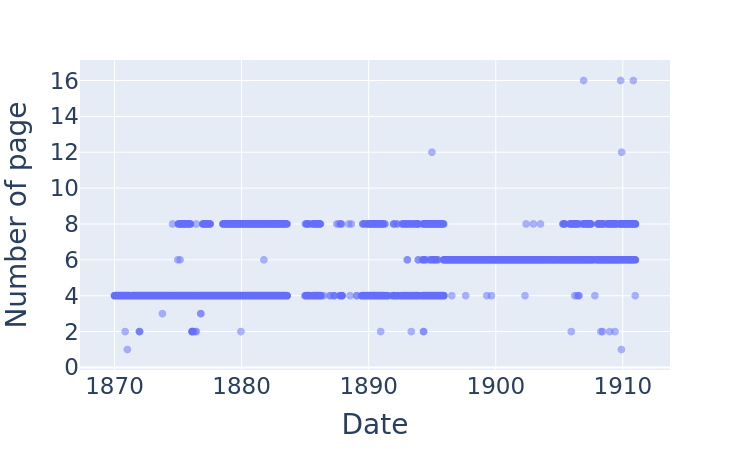

In [121]:
img = px.scatter(textDf, x = 'date', y = 'nPages')
img.update_traces(marker={'size': 8,'opacity' :0.5})
img.update_layout(
    #title="Plot Title",
    xaxis_title="Date",
    yaxis_title="Number of page",
    font_size = 23
    #legend_title="Legend Title",
)
Image(img.to_image(format="png", width=750, height=450))

## Remove unwanted pages (the last ones)

In [178]:
textDf = textDf.drop(columns = 'nPages').copy()
textDf.content = textDf.content.apply(filterPage)
textDf = textDf[textDf.content.apply(len)>0].explode('content').reset_index().drop(columns ='index')
textDf = textDf[textDf.content.apply(len)>0]
textDf['page'] = textDf['content'].apply(lambda page_content : page_content[0])
textDf['content'] = textDf['content'].apply(lambda page_content : page_content[1])
textDf = textDf[textDf.content.apply(len)>0]

## Plot noise density

In [125]:
noise = textDf.copy()
noise.content = noise.content.str.split('\n')
noise = noise.explode('content')
def label(x):
    if x <10 :
        return 'length<10'
    if x <20 :
        return '10<length<50'
    elif x <100: 
        return '50<length<100'
    elif x <200:
        return '100<length<200'
    elif x <500:
        return '200<length<500'
    elif x <1000:
        return '500<length<1000'
    else:
        return '1000<length'

noise['alpha'] = noise['content'].apply(lambda x : getAlphaRatio(x) if len(x) else 0)
noise['len'] = noise['content'].apply(len).apply(label)
noise['realLen'] = noise['content'].apply(len)

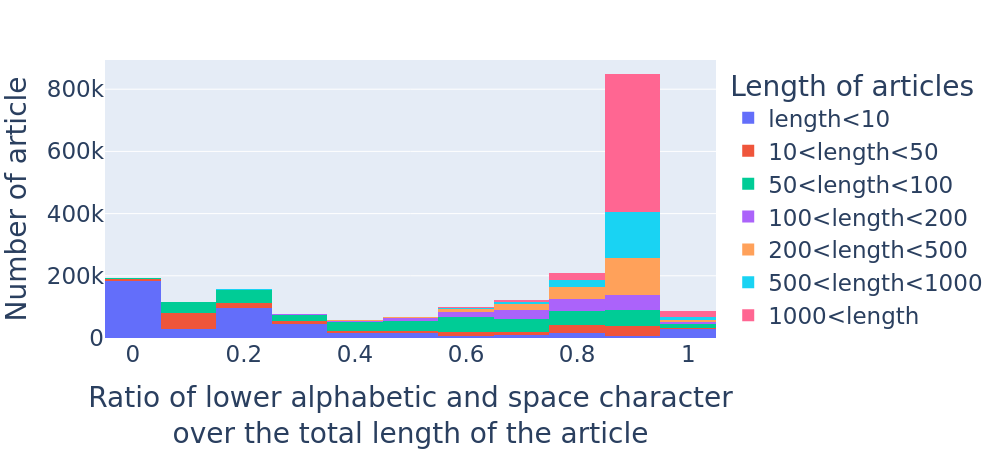

In [126]:
img = px.histogram(noise.sort_values('realLen'), x = 'alpha', color='len', nbins = 20)
img.update_layout(
    #title="Plot Title",
    xaxis_title="Ratio of lower alphabetic and space character<br>over the total length of the article",
    yaxis_title="Number of article",
    font_size = 23,
    legend_title="Length of articles",
)
Image(img.to_image(format="png", width=1000, height=450))

## Remove noisy part of the corpus and clean text by removing unwanted character introduced by OCR

In [179]:
ct = CleanText()
textDf.content = textDf.content.apply(ct.removeNoisyPart)
textDf = textDf.explode('content')
textDf = textDf[~textDf.content.isna()].reset_index().drop(columns='index')
textDf = textDf[textDf.content.apply(len)>250]

In [180]:
textDf.to_csv('data/le_figaro.csv',index=False)

# Word2vec model for recurrent OCR error correction

## Training the model

In [3]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [4]:
textDf = pd.read_csv('data/le_figaro.csv')

In [6]:
textDf['raw_article'] = textDf.content.str.replace('[\!,\.:;\?]',' . ',regex=True)
textDf['raw_article'] = (' '+textDf.raw_article+' ').str.replace('[^\w]\d+[^\w]',' ',regex=True)
raw_articles = textDf['raw_article'].str.split().tolist()
bigram = Phrases(raw_articles, min_count=3, threshold=7.5)
bigram_mod = Phraser(bigram)
raw_articles = list(bigram_mod[raw_articles])

In [7]:
textDf['nGram'] = raw_articles
textDf['nGram'] = textDf['nGram'].apply(' '.join)
textDf.to_csv('data/le_figaro.csv',index=False)

In [10]:
corLexique = textDf.raw_article.str.split().explode().value_counts()
corLexique = corLexique[corLexique>25]
corLexique = corLexique.to_dict()

errLexique = textDf.nGram.str.split().explode().value_counts()
errLexique = errLexique[errLexique>2]
errLexique = errLexique.to_dict()

In [3]:
#textDf = pd.read_csv('data/le_figaro.csv')
#raw_articles = textDf.nGram.str.split().tolist()

In [ ]:
cb = callback()
model = Word2Vec(sentences  = raw_articles,
                 vector_size = 128,
                 window = 5,
                 min_count = 3,
                 sample = 10e-5,
                 sg = 1,
                 epochs = 16,
                 workers = 30,
                 callbacks = [cb],
                 compute_loss = True)
model.save("models/embeddings/Word2Vec_OCR_correction.model")

Loss after epoch 0: 38644304.0
Loss after epoch 1: 22402140.0
Loss after epoch 2: 6842988.0
Loss after epoch 3: 975968.0
Loss after epoch 4: 995240.0
Loss after epoch 5: 1150272.0


In [ ]:
model.wv.most_similar('fameux',topn = 40)

In [ ]:
model.wv.most_similar('progrès',topn = 40)

In [ ]:
model.wv.most_similar('futur',topn = 40)

In [ ]:
model.wv.most_similar('lavenir',topn = 40)

## Make the error-correction pair 

In [ ]:
class Corrector():
    
    def __init__(self,model=False,corLexique=None,errLexique=None):
        self.model = model
        if  corLexique and errLexique:
            self.corLexique = corLexique
            self.errLexique = errLexique
            self.typosPair = {}
            self.segmentationsPair = {}
            self.fusionsPair = {}
        else:
            self.loadData()
        
        self.typoRatio = 15
        self.segRatio = 20
        self.lineBreakPattern = re.compile('[^a-zA-ZÀ-ÿ]?\-[^a-zA-ZÀ-ÿ]?')
        self.toSegmentAgain = None
        
    
    
    def makeCorrectionPair(self, word, wordFreq):
        typos = []
        segmentations = []
        fusions = []
        wordLen = len(word)
        errWordFreq = self.errLexique.get(word,False) # for fusion
        if (wordLen>1) and errWordFreq:
            for simWord, sim in self.model.wv.most_similar(word,topn = 40):
                simWordLen = len(simWord)
                diffLen = simWordLen-wordLen
                simWordFreq = self.errLexique.get(simWord,0)
                if (abs(diffLen) in [0,1,2]) and simWordFreq:
                    if ((wordLen>2) and  (abs(diffLen) in [0,1]) and (sim>0.65) and 
                        (simWordFreq*self.typoRatio<wordFreq)):
                        if not ((word[-1] in '!.?,') or (word[1:].lower() == simWord[1:].lower())):
                            dist = levenshtein(word, simWord, 2)
                            if (diffLen == 0) and (dist == 1):
                                typos.append((simWord,sim))
                            elif ((simWordLen>5) and (sim>0.80) and (dist==2) and 
                                  (simWordFreq*self.typoRatio*4<wordFreq) and 
                                   not (word[1:-2].lower() in simWord[1:].lower())):
                                typos.append((simWord,sim))
                            
                    if (simWordFreq*min(self.segRatio/simWordLen,2)<wordFreq) and (diffLen>0):
                        if simWord.replace('_','') == word: 
                            segmentations.append((simWord,sim))
                        elif  self.lineBreakPattern.sub('',simWord) == word.replace('-',''):
                            segmentations.append((simWord,sim)) 
                    elif (errWordFreq*self.segRatio<simWordFreq) and (diffLen<0): 
                        if (re.sub('[\'\-_]','',simWord) == word):
                            fusions.append((word,sim))
                            word = simWord.replace('_',' ')
                            break
                        
                        
        return word, typos, segmentations, fusions
    
    
    def append(self, word, typos, segmentations, fusions):
        if typos:
            self.typosPair[word]=typos
            
        if segmentations:
            self.segmentationsPair[word]=segmentations
            
        if fusions:
            self.fusionsPair[word]=fusions
        
        
    def getErrors(self):
        getTriple = lambda d : [(correct,error,sim) for correct in d for error,sim in d[correct]]
        typoDf = pd.DataFrame(getTriple(self.typosPair),
                              columns=['correct','error','sim'])
        segDf = pd.DataFrame(getTriple(self.segmentationsPair),
                             columns=['correct','error','sim'])
        fusDf = pd.DataFrame(getTriple(self.fusionsPair),
                             columns=['correct','error','sim'])
        return typoDf,segDf, fusDf
                        
        
    def saveData(self):
        
        self.model.save("models/embeddings/Word2Vec_OCR_correction.model")
        with open('data/lexiques.json','w') as file : 
            json.dump((self.corLexique, self.errLexique), file)
        with open('data/correctionPairs.json','w') as file : 
            json.dump((self.typosPair,self.segmentationsPair,self.fusionsPair), file)
        
        
    def loadData(self):
        if (self.model is None):
            self.model = Word2Vec.load("models/embeddings/Word2Vec_OCR_correction.model")
        with open('data/lexiques.json','r') as file : 
            self.corLexique,self.errLexique = json.load(file)
        with open('data/correctionPairs.json','r') as file :
            self.typosPair,self.segmentationsPair, self.fusionsPair= json.load(file)
        print('Lexique of correct word size: {}'.format(len(self.corLexique)))    
        print('Lexique of error word size: {}'.format(len(self.errLexique)))
        nTypoPair = len([pair for k in self.typosPair for pair in self.typosPair[k]])
        nSegPair = len([pair for k in self.segmentationsPair for pair in self.segmentationsPair[k]])
        nFusPair = len([pair for k in self.fusionsPair for pair in self.fusionsPair[k]])
        print('Number of correct/error for typo  : {}'.format(nTypoPair))
        print('Number of correct/error for segmentation  : {}'.format(nSegPair))
        print('Number of correct/error for fusion  : {}'.format(nFusPair))
        
    def setCorrectors(self):
        self.typoDf, self.segDf, self.fusDf = self.getErrors()
        
        self.typoDf['errCompiled'] = ('(?<=[^a-zA-ZÀ-ÿ])'+
                                      self.typoDf['error']+
                                      '(?=e?s?[^a-zA-ZÀ-ÿ])').apply(re.compile)
        self.fusDf['errCompiled'] = ('(?<=[^a-zA-ZÀ-ÿ])'+
                                      self.fusDf['error']+
                                      '(?=[^a-zA-ZÀ-ÿ])').apply(re.compile)

        self.segDf['errCompiled'] = ('(?<=[^a-zA-ZÀ-ÿ])'+
                                     self.segDf['error'].replace('(?<=\w)[_\-]+(?=\w)','[ \-]{1,2}', regex=True)+
                                     '(?=e?s?[^a-zA-ZÀ-ÿ])').apply(re.compile)
        self.typoDf = self.typoDf.sort_values('sim').drop_duplicates(['errCompiled'])
        self.fusDf = self.fusDf.sort_values('sim').drop_duplicates(['errCompiled'])
        self.segDf = self.segDf.sort_values('sim').drop_duplicates(['errCompiled'])
        self.segDf['error'] = self.segDf['error'].str.split('[_\-]+',regex=True).apply(lambda l : [w for w in l if w])
        
        self.typoDict = self.typoDf.drop(columns = 'sim').set_index('errCompiled').to_dict(orient = 'index')
        self.segDict = self.segDf.drop(columns = 'sim').set_index('errCompiled').to_dict(orient = 'index')
        self.fusDict = self.fusDf.drop(columns = 'sim').set_index('errCompiled').to_dict(orient = 'index')
        
    def applyCorrection(self,index,text):
        nSub = 0
        text = ' ' + text + ' '
        for errCompiled,row in self.segDict.items():
            if all(w in text for w in row['error']):
                text,n = errCompiled.subn(row['correct'],text)
                nSub+=n
        for errCompiled,row in self.fusDict.items():
            if row['error'] in text:
                text,n = errCompiled.subn(row['correct'],text)
                nSub+=n
        for errCompiled,row in self.typoDict.items():
            if row['error'] in text:
                text,n = errCompiled.subn(row['correct'],text)
                nSub+=n
        return index, ' '.join(text.split()),nSub
    
    
    def setToSegment(self, wordCountDict):
        self.toSegment = [(w,count)                                     
                          for w,count in wordCountDict.items() 
                          if '-' in w and (count < 100)]
        checkCount = lambda w,count : all((wordCountDict.get(s,0)>=count*10) for s in w.split('-')) and (count<50)
        getAlternative = lambda w,count : (w.replace('-',' ')
                                           if (count*15<wordCountDict.get(w.replace('-',''),0)) 
                                           else w)
        makeRep = lambda w,count : w.replace('-',' ') if checkCount(w,count) else getAlternative(w,count)
        
        self.toSegment = [(w,
                           re.compile('(?<=[^a-zA-ZÀ-ÿ])'+w+'(?=e?s?[^a-zA-ZÀ-ÿ])'), 
                           makeRep(w,count)) 
                          for w,count in self.toSegment 
                          if '-' in w and (count < 100)]
    
    def finalSegmentation(self, text):
        nSub = 0
        text = ' ' + text + ' '
        for w, reW, wRep in self.toSegment:
            if w in text:
                text,n = reW.subn(wRep,text)
                nSub+=n
        return ' '.join(text.split()),nSub
                        
                    
        

In [ ]:
corrector = Corrector(model,corLexique,errLexique)

In [ ]:
words = [w for w,_ in corrector.corLexique.items()]
freqs = [f for _,f in corrector.corLexique.items()]
gc.collect()
with ProcessPoolExecutor(max_workers=20) as executor:
    for word, typos, segmentations, fusions in executor.map(corrector.makeCorrectionPair, words, freqs, chunksize=2000):
        corrector.append(word, typos, segmentations, fusions)
corrector.saveData()

In [ ]:
a,b,c = corrector.getErrors()

In [ ]:
c

In [ ]:
corrector.setCorrectors()

In [214]:
for i in range(5):
    t = time.time()

    test,n = corrector.applyCorrection(textDf.iloc[i].content)
    print(time.time()-t)
    print(n,test)

0.007100343704223633
0 Nouvelles i la Main Une dame s'étonne du refus incom préhensible de sa bonne de conduire les enfants-dans une baraque-foraine du voisinage où l'on montre des animaux savants. Pressée de questions, elle finit par donner cette explication naïve : v Eh bien, voilà, madame : onjm'a dit chez la fruitière qu'il y a là-dedans un âne qui s'arrête devant la personne la plus amoureuse de la société... Je se rais trop honteuse si c'était moi.
0.027434587478637695
7 Nous avons reçu de M. Marcel Leroy-Dupré, pour le Denier des veuves et des vieillards , la somme de 100 francs, que nous faisons parvenir à cette œuvre si utile j Rappelons que les dons doivent être adressés directement à M. Alfred Mé-zières, de l'Académie française, président de l' uvre du Denier des veuves et ides vieillards, rue de la Grande-Bate lière i iaa o . Les chevaliers de l'ordre du Cambodge et de l'Etoile d'Anjouan ne le pardon neront jamais au général Davout! Le grand chancelier de la Légion d'honneu

In [202]:
print(0,textDf.iloc[0].content)

0 Nouvelles i la Main Une dame s'étonne du refus incom préhensible de sa bonne de conduire les enfants-dans une baraque-foraine du voisinage où l'on montre des animaux savants. Pressée de questions, elle finit par donner cette explication naïve : v Eh bien, voilà, madame : onjm'a dit chez la fruitière qu'il y a là-dedans un âne qui s'arrête devant la personne la plus amoureuse de la société... Je se rais trop honteuse si c'était moi.


## Apply the corrections

In [ ]:
typoDf, segDf = corrector.getErrors()

In [ ]:
totalSub = 0
texts = [(ind,row['content']) for ind,row in textDf.iterrows()]
index = [ind for ind,_ in texts]
texts = [text for _,text in texts]
textsCorrected = {}
corrector.setCorrectors()
with ProcessPoolExecutor(max_workers=30) as executor:
    for indice, corrected, n in executor.map(corrector.applyCorrection, texts, index, chunksize=200):
        textsCorrected[indice] = text
        totalSub+=n
        

    
textDf['corrected'] = pd.Series(textDf.index).apply(textsCorrected)

In [ ]:
textDf.to_csv('data/le_figaro.csv',index=False)

In [ ]:
wordCount = textDf['corrected'].str.split().value_counts()
with open('data/countCorrected.txt','w') as file:
    file.write("corrected : {}, ratio : {}".format(totalSub,totalSub/wordCount.sum()))

corrector.setToSegment(wordCount.to_dict())
textDf['correctedFinal'] = textDf['corrected'].apply(corrected.finalSegmentation)
totalSub+= textDf['correctedFinal'].apply(lambda pair : pair[1]).sum()
textDf['correctedFinal']= textDf['correctedFinal'].apply(lambda pair : pair[0]).sum()
with open('data/countFinalCorrected.txt','w') as file:
    file.write("corrected : {}, ratio : {}".format(totalSub,totalSub/wordCount.sum()))
textDf.to_csv('data/le_figaro.csv',index=False)